82 paskaita

Viena užduotis maždaug vienai paskaitai. Techniniai reikalavimai – Jupyter Notebook’as arba Streamlit aplinka. Grafikai turi turėti pavadinimus, ašys pavadintos prasmingai, jei grafike yra daugiau nei viena kreivė – legenda būtina. Panaudoti boxplot, swarmplot, heatmap, pairplot, (h)bar, histogram, scatter.

Būtina pasirašyti 1 – 2 sakinius į JupyterNotebook’ą apie tai, ką matote, ką galite pasakyti iš grafiko (ką matote grafike, 1-2 sakiniai vienam grafikui, tad jei turėsite 10 grafikų – 20 sakinių).

2. TBC duomenys
https://data.gov.lt/datasets/2871/

(tuberkulioze – rūkymas, gėrimas, lytis, TLK kodas, mirties data)

Ar yra priklausomybė tarp gyvenimo trukmės ir TBC žalingų įpročių? Pateikite TBC sergančiųjų duomenų apžvalgą: pasiskirstymas pagal lytį, amžių, rūkymo/alkoholio vart. stažą. Parašykite skriptą, kuris prognozuotų tikėtiną paciento gyvenimo trukmę.

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from datetime import datetime as dt
import warnings; warnings.filterwarnings('ignore')
print('Pasiruošta',dt.now().replace(microsecond=0))

data_dir='../../../duomenys/data_gov_lt' # atsisiųsti failai
data_file='TubPacientoZalingasIprotis.csv'

Pasiruošta 2025-02-03 03:39:20


In [66]:
tbc_df = pd.read_csv(f"{data_dir}/{data_file}")

In [67]:
print(tbc_df.columns.tolist)

<bound method IndexOpsMixin.tolist of Index(['_type', '_id', '_revision', '_page.next', 'paciento_id',
       'paciento_vardas', 'paciento_pavarde', 'paciento_gim_data',
       'paciento_asmens_kodas', 'vda_ak_validacija',
       'vda_paciento_gim_metai_ak', 'paciento_gim_metai',
       'vda_paciento_lytis_ak', 'paciento_lytis', 'rukymas_id',
       'rukymas_reiksme', 'rukymo_stazas_id', 'rukymo_stazas_reiksme',
       'alkoholis_id', 'alkoholis_reiksme', 'vda_ligos_kodai', 'ligos_kodas',
       'ar_mire_nuo_tub', 'mirties_nuo_tub_d'],
      dtype='object')>


In [68]:
tbc_df.head(3)

,_type,_id,_revision,_page.next,paciento_id,paciento_vardas,paciento_pavarde,paciento_gim_data,paciento_asmens_kodas,vda_ak_validacija,...,rukymas_id,rukymas_reiksme,rukymo_stazas_id,rukymo_stazas_reiksme,alkoholis_id,alkoholis_reiksme,vda_ligos_kodai,ligos_kodas,ar_mire_nuo_tub,mirties_nuo_tub_d
0,datasets/gov/santara/tub_pacientu_zalingi_ipro...,da2bbb1c-2884-48bc-bdfd-19b27ff97025,76cab5cc-7551-4c30-8df1-537f5c036a5a,NaN,000254ba808ae65,7a0f681b673018a,2a925dd8f6a43f2,cf71c293a267455,2e0500a37929dcc,Tinkamas,...,2.0,11-20 cigarečių per dieną,3.0,11 - 20 metų,1.0,Nevartoja,A15d,A15d,NaN,NaN
1,datasets/gov/santara/tub_pacientu_zalingi_ipro...,eb2639f9-29b6-4d6c-888b-5eb2506dbb19,c3d871f4-5b93-4d88-aaae-0a6e9fe7daf3,NaN,0002a198424b859,d69d675af2a2fef,743a21b9b51c547,565e6a3a976e20a,aa6024f3d69f070,Tinkamas,...,4.0,Nerūko,0.0,NaN,2.0,Vartoja retai,A19.1,A19.1,NaN,NaN
2,datasets/gov/santara/tub_pacientu_zalingi_ipro...,63712b95-d93c-4f25-8e0e-117822d05575,92c2ea5d-851e-4739-a504-da8cf375f0f7,NaN,00043169b1fdc6c,fcd863544e185ea,8d78f1941f5609b,0cf907d261a93b3,97fdc9b065f1ab7,Tinkamas,...,2.0,11-20 cigarečių per dieną,4.0,Virš 20 metų,2.0,Vartoja retai,A15,A15,False,NaN


In [69]:
print(tbc_df.shape)

tbc_df.dropna(thresh=int(0.1*len(tbc_df)), axis=1, inplace=True)
# tbc_df.dropna(axis=1, inplace=True)

# Pašalinti stulpelius, kurie prasideda 'paciento', išskyrus 'paciento_kodas'
tbc_df = tbc_df.loc[:, ~tbc_df.columns.str.startswith('paciento') | (tbc_df.columns=='paciento_kodas')]

print(tbc_df.shape)

(52139, 24)
(52139, 16)


In [70]:
tbc_df['vda_paciento_gim_metai_ak']

0        1978-01-01
1        1967-01-01
2        1952-01-01
3        1919-01-01
4        1937-01-01
            ...    
52134    1959-01-01
52135           NaN
52136    1931-01-01
52137    1930-01-01
52138           NaN
Name: vda_paciento_gim_metai_ak, Length: 52139, dtype: object

In [72]:
def trinti_cols(stulpeliai_istrinti,df):
    # Pašalinti stulpelius tik jei jie egzistuoja
    stulpeliai_istrinti = [col for col in stulpeliai_istrinti if col in df.columns]
    return df.drop(columns=stulpeliai_istrinti)

print(tbc_df.shape)

# Convert to datetime format
tbc_df['gim_data'] = pd.to_datetime(tbc_df['vda_paciento_gim_metai_ak'])
tbc_df['mir_data'] = pd.to_datetime(tbc_df['mirties_nuo_tub_d'])
tbc_df['amzius'] = tbc_df['mir_data'].dt.year - tbc_df['gim_data'].dt.year

tbc_df = trinti_cols(['vda_paciento_gim_metai_ak','mirties_nuo_tub_d','paciento_3'],tbc_df)

print(tbc_df.shape)

(52139, 19)
(52139, 17)


In [73]:
import pandas as pd

# Inicializuojame tuščią DataFrame, kad talpintume reikšmių sumas
value_counts_matrix = pd.DataFrame(index=tbc_df.columns, columns=tbc_df.columns)

# Lyginame kiekvieną stulpelį su kitais ir skaičiuojame unikalių reikšmių poras
for col1 in tbc_df.columns:
    for col2 in tbc_df.columns:
        # if col1 != col2:
            # Skirtingų reikšmių skaičius tarp dviejų stulpelių
            unique_values = len(set(zip(tbc_df[col1], tbc_df[col2])))
            value_counts_matrix.loc[col1, col2] = unique_values

# Peržiūrėkite rezultatus
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Skirtingų reikšmių skaičiaus matrica", dataframe=value_counts_matrix)

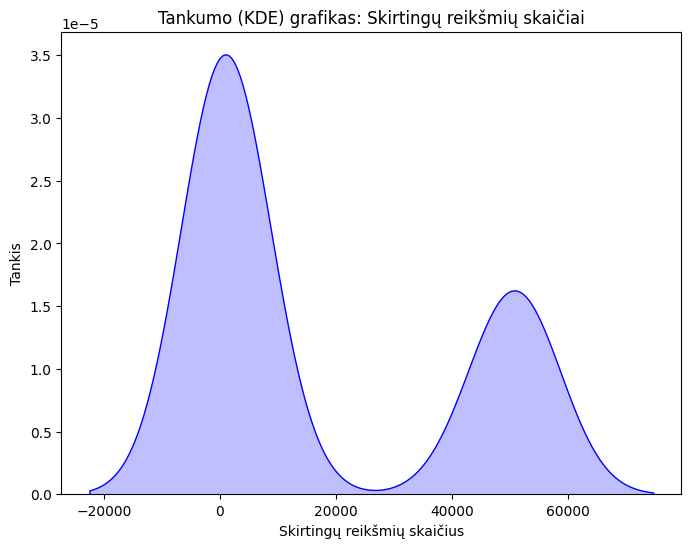

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Paverčiame value_counts_matrix į vieną sąrašą
flat_values = value_counts_matrix.values.flatten()

# Sukuriame tankumo (KDE) grafiką
plt.figure(figsize=(8, 6))
sns.kdeplot(flat_values, shade=True, color="b")

# Pridėkime pavadinimą ir rodykime grafiką
plt.title("Tankumo (KDE) grafikas: Skirtingų reikšmių skaičiai")
plt.xlabel("Skirtingų reikšmių skaičius")
plt.ylabel("Tankis")
plt.show()

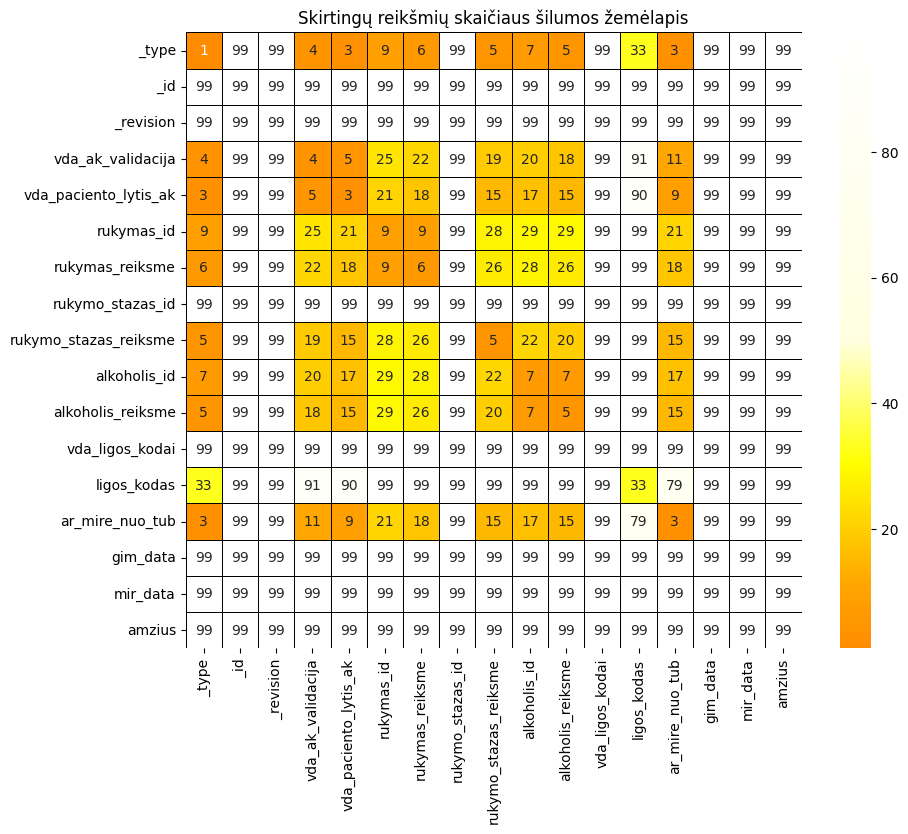

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pašaliname langelius, kurių reikšmės didesnės nei 99 (keitimo vieta į NaN/99)
filtered_matrix = value_counts_matrix.applymap(lambda x: 99 if x > 99 else x)

# Sukuriame custom spalvų paletę
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_cmap", [(0, "darkorange"), (0.1, "orange"), (0.3, "yellow"), (0.5, "lightyellow"), (1, "white")]
)

# Kurkite šilumos žemėlapį
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_matrix, annot=True, cmap=cmap, cbar=True, square=True, linewidths=0.5, linecolor='black')

# Parodome
plt.title('Skirtingų reikšmių skaičiaus šilumos žemėlapis')
plt.show()